In [4]:
pip install pandas numpy matplotlib seaborn scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Step 1: Load the Data and Basic Preparation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# Load the data
data_path = r"C:\Users\rajni\Downloads\beer_data.csv"
df = pd.read_csv(data_path)

# Display basic information
print("Data Shape:", df.shape)
print(df.head())
print(df.info())

# Check for missing values
print("Missing Values:\n", df.isnull().sum())


Data Shape: (475984, 3)
   beer_beerid review_profilename  review_overall
0        48215            stcules             3.0
1        52159            oline73             3.0
2        52159       alpinebryant             3.0
3        52159            rawthar             4.0
4        52159        RangerClegg             3.5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475984 entries, 0 to 475983
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   beer_beerid         475984 non-null  int64  
 1   review_profilename  475884 non-null  object 
 2   review_overall      475984 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 10.9+ MB
None
Missing Values:
 beer_beerid             0
review_profilename    100
review_overall          0
dtype: int64


Step 2: Filter Beers with at Least N Reviews

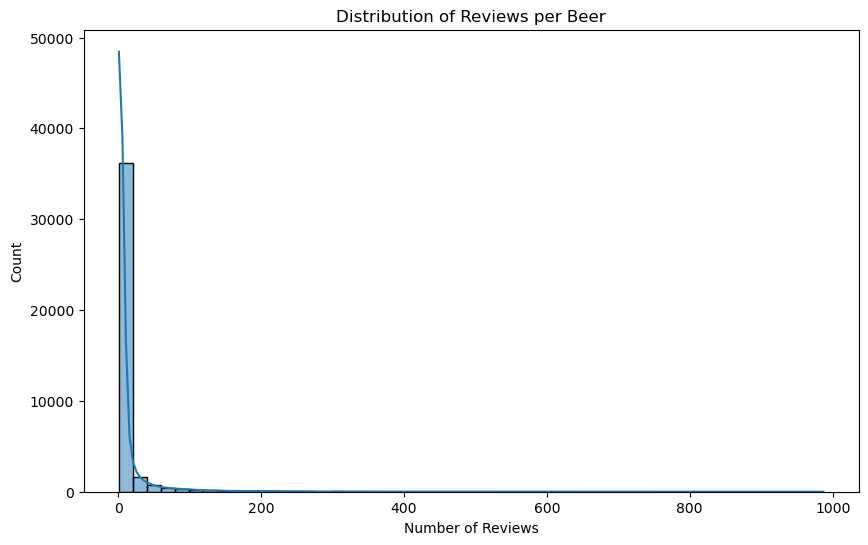

Filtered Data Shape: (297346, 3)


In [5]:
# Calculate the number of reviews per beer
beer_reviews = df['beer_beerid'].value_counts()

# EDA: Visualize distribution of reviews per beer
plt.figure(figsize=(10, 6))
sns.histplot(beer_reviews, bins=50, kde=True)
plt.title("Distribution of Reviews per Beer")
plt.xlabel("Number of Reviews")
plt.ylabel("Count")
plt.show()

# Filter beers with at least N reviews (choose N based on analysis, e.g., N=50)
N = 50
popular_beers = beer_reviews[beer_reviews >= N].index
filtered_df = df[df['beer_beerid'].isin(popular_beers)]

print("Filtered Data Shape:", filtered_df.shape)


Step 3: Unique Rating Values

In [7]:
# Unique values of ratings
unique_ratings = filtered_df['review_overall'].unique()
print("Unique Rating Values:", unique_ratings)


Unique Rating Values: [3.  4.5 4.  5.  3.5 2.  2.5 1.5 1. ]


Step 4: Visualizations

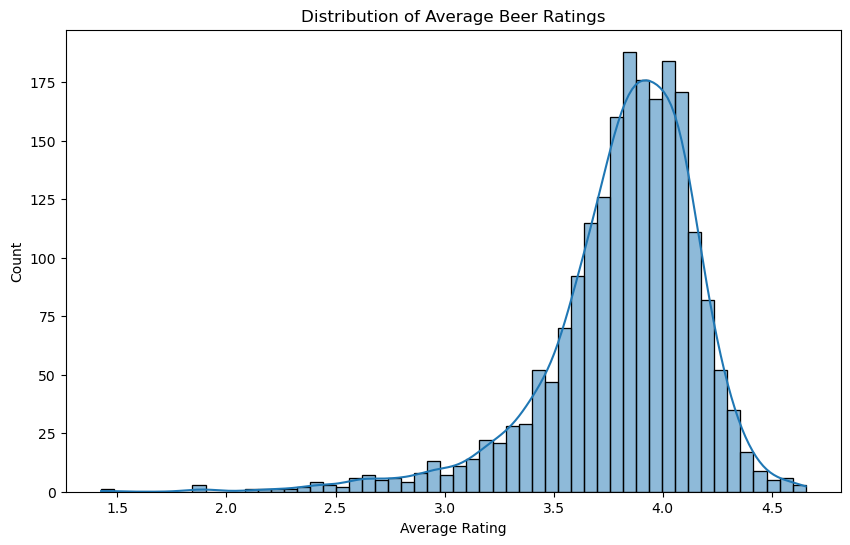

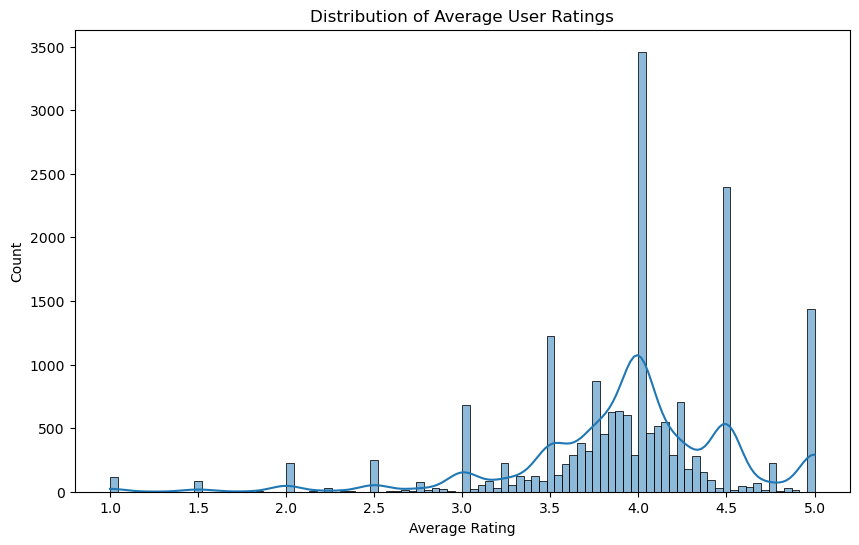

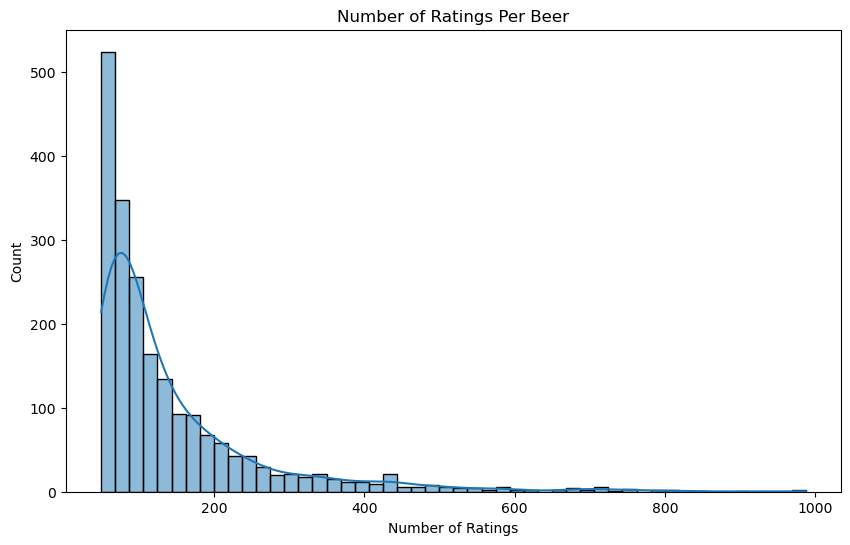

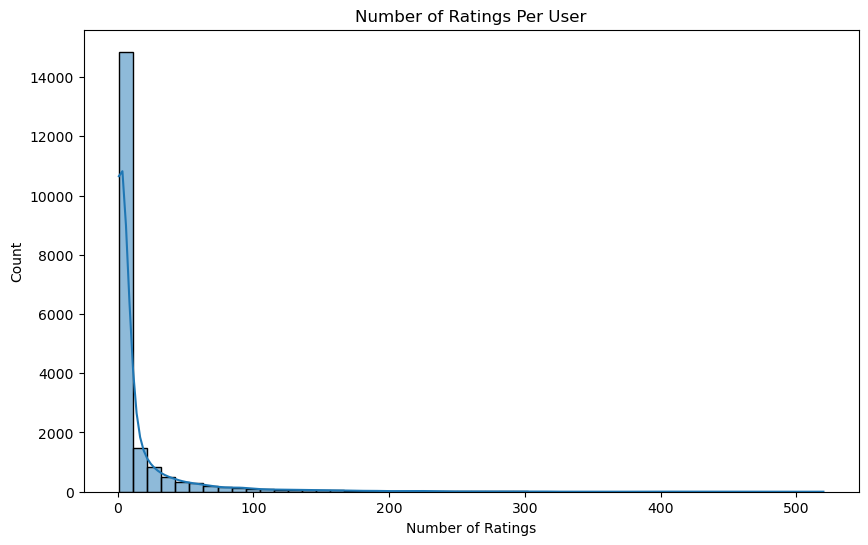

In [9]:
# Average beer ratings
avg_beer_ratings = filtered_df.groupby('beer_beerid')['review_overall'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(avg_beer_ratings, kde=True)
plt.title("Distribution of Average Beer Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Count")
plt.show()

# Average user ratings
avg_user_ratings = filtered_df.groupby('review_profilename')['review_overall'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(avg_user_ratings, kde=True)
plt.title("Distribution of Average User Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Count")
plt.show()

# Average number of ratings given to beers
num_ratings_per_beer = filtered_df.groupby('beer_beerid')['review_overall'].count()
plt.figure(figsize=(10, 6))
sns.histplot(num_ratings_per_beer, bins=50, kde=True)
plt.title("Number of Ratings Per Beer")
plt.xlabel("Number of Ratings")
plt.ylabel("Count")
plt.show()

# Average number of ratings given by users
num_ratings_per_user = filtered_df.groupby('review_profilename')['review_overall'].count()
plt.figure(figsize=(10, 6))
sns.histplot(num_ratings_per_user, bins=50, kde=True)
plt.title("Number of Ratings Per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Count")
plt.show()


Step 5: Divide Data into Training and Testing Sets

In [11]:
# Pivot the data for collaborative filtering
pivot_df = filtered_df.pivot_table(index='review_profilename', columns='beer_beerid', values='review_overall')

# Train-test split
train_df, test_df = train_test_split(pivot_df, test_size=0.2, random_state=42)
print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)


Train Shape: (15596, 2069)
Test Shape: (3900, 2069)


Step 6: User-Based Collaborative Filtering

User Similarity Matrix Shape: (15596, 15596)


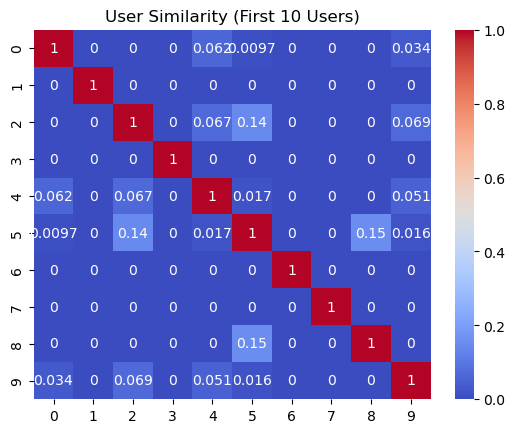

In [13]:
# Fill missing values with 0 for similarity computation
train_matrix = train_df.fillna(0).values

# Compute user similarity
user_similarity = cosine_similarity(train_matrix)
print("User Similarity Matrix Shape:", user_similarity.shape)

# Visualize similarity for first 10 users
sns.heatmap(user_similarity[:10, :10], cmap="coolwarm", annot=True)
plt.title("User Similarity (First 10 Users)")
plt.show()


Step 7: Item-Based Collaborative Filtering

Beer Similarity Matrix Shape: (2069, 2069)


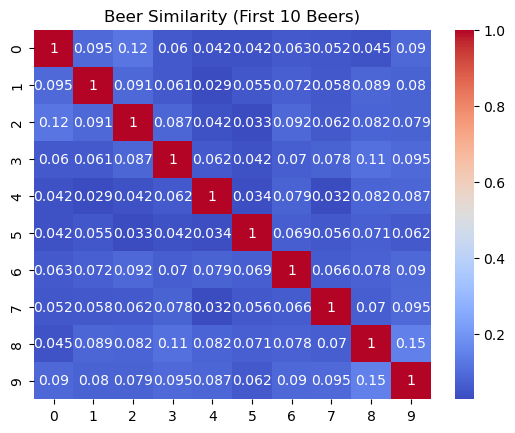

In [15]:
# Compute beer similarity
beer_similarity = cosine_similarity(train_matrix.T)
print("Beer Similarity Matrix Shape:", beer_similarity.shape)

# Visualize similarity for first 10 beers
sns.heatmap(beer_similarity[:10, :10], cmap="coolwarm", annot=True)
plt.title("Beer Similarity (First 10 Beers)")
plt.show()


Step 8: Model Performance Comparison

In [21]:
# User-based predictions
user_predictions = predict_ratings(user_similarity, train_matrix, kind='user')

# Item-based predictions (corrected)
item_predictions = predict_ratings(beer_similarity, train_matrix, kind='item')

# RMSE calculation
def calculate_rmse(predictions, actuals):
    mask = actuals != 0  # Only calculate RMSE for non-zero ratings
    return np.sqrt(mean_squared_error(actuals[mask], predictions[mask]))

# RMSE for both models
user_rmse = calculate_rmse(user_predictions, train_matrix)
item_rmse = calculate_rmse(item_predictions, train_matrix)

print("User-Based Model RMSE:", user_rmse)
print("Item-Based Model RMSE:", item_rmse)


User-Based Model RMSE: 3.600997782441994
Item-Based Model RMSE: 3.668920849937367


Step 9: Recommend Top 5 Beers for Users

In [19]:
# Recommend beers to specific users
def recommend_beers(user_id, predictions, beer_ids, top_n=5):
    user_idx = list(train_df.index).index(user_id)
    sorted_indices = np.argsort(predictions[user_idx])[::-1]
    top_beers = [beer_ids[i] for i in sorted_indices[:top_n]]
    return top_beers

# Get beer IDs
beer_ids = list(train_df.columns)

# Top 5 recommendations for users 'cokes', 'genog', and 'giblet'
users = ['cokes', 'genog', 'giblet']
for user in users:
    try:
        user_recommendations = recommend_beers(user, user_predictions, beer_ids)
        print(f"Top 5 Beers for {user} (User-Based): {user_recommendations}")
    except ValueError:
        print(f"User '{user}' not found in training data.")


Top 5 Beers for cokes (User-Based): [2093, 695, 1708, 276, 412]
Top 5 Beers for genog (User-Based): [17112, 88, 34, 731, 680]
Top 5 Beers for giblet (User-Based): [92, 276, 695, 6108, 17112]
